# One versus all as a anomaly detection problem on CIFAR10

Inspired from Ruff 2018.

In this study, we train each our model to identify one of the ten digits in the MNIST dataset. All the other digits are considered as "outliers" ; they are not seen during training, and during evaluation the model has to predict if an image is in the normal class or in the outlier class.

This evaluation method will be our standard to test the performances of a model. We will use the classification metrics ROC-AUC to measure the performance of a model and compare them with pre-existing methods.

In [1]:
!pip install git+https://github.com/jeanollion/dataset_iterator.git
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt

# DRIVE
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

# from uad.callbacks.metrics import AUCCallback, PrecisionRecallCallback
from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

!nvidia-smi

  Cloning https://github.com/jeanollion/dataset_iterator.git to /tmp/pip-req-build-83wf6ryf
  Running command git clone -q https://github.com/jeanollion/dataset_iterator.git /tmp/pip-req-build-83wf6ryf
  Created wheel for dataset-iterator: filename=dataset_iterator-0.0.1-cp36-none-any.whl size=35945 sha256=89465bb08d17309d4fc243002ac13b49bbcef9ed11465c445fd1875602678b4d
  Stored in directory: /tmp/pip-ephem-wheel-cache-w7wsx8kz/wheels/e1/b1/4a/efb8888afaa53e058db8520c203e13af93ca10b2a8d42ab098
Successfully built dataset-iterator
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonl

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Fri Jul 31 13:27:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dataset

In [2]:
dataset_path = "/home/cifar10.h5"

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
out_file= h5py.File(dataset_path, 'w')
out_file.create_dataset("cifar10/train/images", data = train_images)
out_file.create_dataset("cifar10/train/labels", data = train_labels)
out_file.create_dataset("cifar10/eval/images", data = test_images)
out_file.create_dataset("cifar10/eval/labels", data = test_images)
out_file.close()

# sort per class
dataset_path_class = "/home/cifar10_class.h5"

out_file= h5py.File(dataset_path_class, 'w')
for c in range(10):
    out_file.create_dataset("cifar10/train/{}/images".format(c), data = train_images[train_labels.squeeze(-1)==c])
    out_file.create_dataset("cifar10/train/{}/labels".format(c), data = train_labels[train_labels.squeeze(-1)==c])
    out_file.create_dataset("cifar10/eval/{}/images".format(c), data = test_images[test_labels.squeeze(-1)==c])
    out_file.create_dataset("cifar10/eval/{}/labels".format(c), data = test_labels[test_labels.squeeze(-1)==c])
out_file.close()

170500096/170498071 [==============================] - 6s 0us/step


In [6]:
from dataset_iterator import MultiChannelIterator, PreProcessingImageGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

corruption_function = lambda im : im + np.random.normal(0, 5, im.shape) # define here a corruption function that input a singla image and return and image of same shape

data_gen = ImageDataGenerator(
                              horizontal_flip=True,
                            #   vertical_flip=True,
                              height_shift_range=0.2,
                              width_shift_range=0.2,
                              channel_shift_range=0.2,
                              rescale=1./255, # to have values in range [0, 1]
                              fill_mode="nearest",)
                            #   preprocessing_function=corruption_function)


interest_digit = 7

image_scaling = PreProcessingImageGenerator(lambda im:im/255.) # simple scaling of 8-bit images -> data in [0, 1]

# train set, interest class only
x_train = MultiChannelIterator(dataset=dataset_path_class, 
                                channel_keywords=["/images"], 
                                group_keyword = f"train/{interest_digit}/", 
                                input_channels=[0],
                                output_channels=[0], 
                                image_data_generators=[data_gen],
                                batch_size=30
                                )

x_train, x_val = x_train.train_test_split(test_size=0.1)

# evaluation set, grouped by class
x_test = MultiChannelIterator(dataset = dataset_path_class, 
                                channel_keywords=["/images", "/labels"], 
                                group_keyword = ["train/{}/".format(c) for c in range(10)],
                                input_channels=[0],
                                output_channels=[0, 1], 
                                image_data_generators= [image_scaling, None],
                                batch_size=50
                                )

x_test.group_proportion = [0.55 if i == interest_digit else 0.05 for i in range(10)]

print(f"number of train/validation batches for class 0: {len(x_train)}/{len(x_val)}")

number of train/validation batches for class 0: 150/17


In [ ]:
# find appropriate batch size

for i in range(1,100):
    if len(x_test) % i == 0:
        print(i)

1
2
4
5
10
20
25
50


In [7]:
def plot_images(batch_x, batch_y, n=3, labx=None, laby=None):
  plt.figure(figsize=(n*3, 6))
  for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(np.clip(batch_x[i], 0, 1))
    if labx is not None:
        plt.title(label=int(labx[i].squeeze(-1)))
    plt.axis("off")
    plt.subplot(2, n, n+i+1)
    plt.imshow(np.clip(batch_y[i], 0, 1))
    if laby is not None:
        plt.title(label=int(labx[i].squeeze(-1)))
    plt.axis("off")

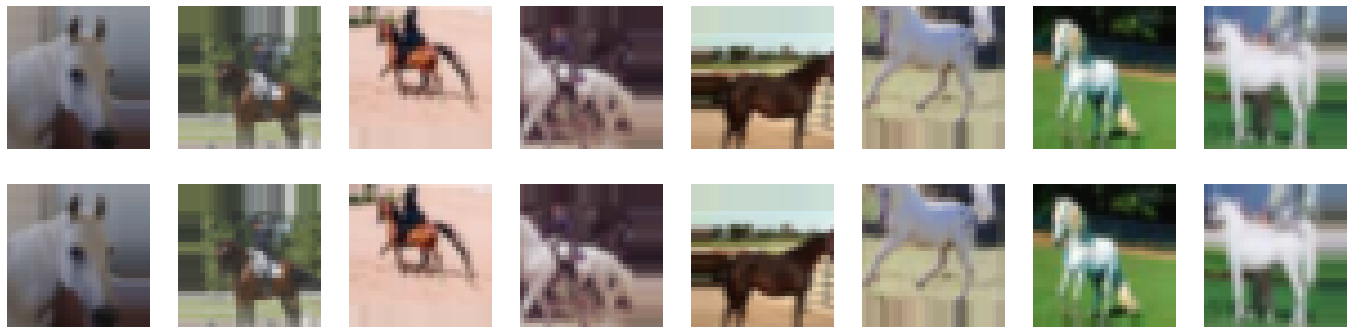

In [8]:
# To get images and labels

bx, by = x_train[1]

# imx, labx = bx
# imy, laby = by

# plot_images(bx, by, n=8, labx=labx, laby=laby)
plot_images(bx, by, n=8, labx=None, laby=None)

## Build model

For this introduction, the model will learn to reconstruct the digit 0.

## U-Net architecture

Doesn't perform well for now

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim1, dim2, dim3 = tf.shape(z_mean)[1], tf.shape(z_mean)[2], tf.shape(z_mean)[3]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim1, dim2, dim3))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def conv2d_block(input_tensor, n_filters, kernel_size=(3, 1), batchnorm=True,
                 activation="relu"):
    """Function to add 2 convolutional layers with the parameters passed to it
    activation1: name of the activation function to apply. If none, pass "" (empty string)
    activation2: name of the activation function to apply. If none, pass "" (empty string)
    """
    # first layer
    x = layers.Conv2D(filters=n_filters, kernel_size=kernel_size,
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation == "relu" or activation == "sigmoid" or activation == "linear":
        x = layers.Activation(activation)(x)
    elif activation == "leaky_relu":
        x = tf.keras.layers.LeakyReLU(alpha=0.3)(x)
    else:
        raise NotImplementedError("activation function should be given by a valid string of leaky_relu")

    # second layer
    x = layers.Conv2D(filters=n_filters, kernel_size=kernel_size,
                      kernel_initializer='he_normal', padding='same')(x)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation == "relu" or activation == "sigmoid" or activation == "linear":
        x = layers.Activation(activation)(x)
    elif activation == "leaky_relu":
        x = tf.keras.layers.LeakyReLU(alpha=0.3)(x)
    else:
        raise NotImplementedError("activation function should be given by a valid string of leaky_relu")

    return x


In [26]:
n_filters = 60
n_contractions = 3
input_dims = (32, 32, 3)
latent_depth = n_filters * int(2**n_contractions)
latent_dims = (int(32 / (2**n_contractions)), int(32 / (2**n_contractions)), latent_depth)
batchnorm, dropout = False, 0.2
k_size = (3, 3)

encoder_inputs = layers.Input(shape=input_dims, name="encoder_inputs")

# contracting path
for i in range(n_contractions):
    if i == 0:
        x = conv2d_block(encoder_inputs, n_filters * 2**i, kernel_size=k_size, 
                         batchnorm=batchnorm, activation="relu")
    else:
        x = conv2d_block(x, n_filters * 2**i, kernel_size=k_size, batchnorm=batchnorm,
                         activation="relu")
    x = layers.MaxPooling2D((2, 2))(x)
    # x = layers.Dropout(dropout)(x)
    x = layers.SpatialDropout2D(rate=dropout)(x)

z_mean = layers.Conv2D(latent_depth, 1, strides=1, name="z_mean")(x)
z_log_var = layers.Conv2D(latent_depth, 1, strides=1, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Define decoder model.
latent_inputs = layers.Input(shape=latent_dims, name="z_sampling")

for i in range(n_contractions - 1, 0, -1):
    if i == n_contractions - 1:
        x = layers.Conv2DTranspose(n_filters * 2**i, k_size, strides=(2, 2), 
                                   padding='same')(latent_inputs)
    else:
        x = layers.Conv2DTranspose(n_filters * 2**i, k_size, strides=(2, 2), 
                                   padding='same')(x)
    # x = layers.Dropout(dropout)(x)
    x = layers.SpatialDropout2D(rate=dropout)(x)
    x = conv2d_block(x, n_filters * 2**i, kernel_size=k_size, batchnorm=batchnorm,
                     activation="relu")

x = layers.Conv2DTranspose(n_filters, kernel_size=k_size, strides=(2, 2), 
                            padding='same')(x)
# x = layers.Dropout(dropout)(x)
x = layers.SpatialDropout2D(rate=dropout)(x)
x = layers.Conv2D(3, kernel_size=k_size, padding="same")(x)

decoder = Model(inputs=latent_inputs, outputs=x, name="decoder")

## LeNet architecture

From Ruff

In [13]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.regularizers import l2
from uad.models.variational_autoencoder import Sampling

def get_ruff_vae(input_dims=(32, 32, 3), n_filters=(32, 64, 128), k_size=(5, 5), LAMBDA=1e-6,
                  spatial_dropout=0.2, dropout=0, batchnorm=False):
    """
    LeNet-type architecture descirbed by Ruff et al. in their publication
    :param input_dims:
    :param n_filters:
    :param dense_sizes:
    :param k_size:
    :param LAMBDA:
    :param spatial_dropout:
    :param dropout:
    :param batchnorm:
    :return:
    """
    inputs = tf.keras.Input(shape=input_dims)

    # contraction
    n_contractions = len(n_filters)
    for i in range(n_contractions):
        if i == 0:
            x = layers.Conv2D(filters=n_filters[i], kernel_size=k_size, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                              padding="same", name=f"conv_1")(inputs)
        else:
            x = layers.Conv2D(filters=n_filters[i], kernel_size=k_size, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                              padding="same")(x)
        if spatial_dropout != 0:
            x = layers.SpatialDropout2D(spatial_dropout)(x)
        if dropout != 0:
            x = layers.Dropout(dropout)(x)
        if batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        x = layers.MaxPooling2D((2, 2))(x)

    latent_depth = int(n_filters[0] * (2 ** n_contractions))
    latent_dims = (int(input_dims[0] / (2 ** n_contractions)), int(input_dims[1] / (2 ** n_contractions)), latent_depth)

    z_mean = layers.Conv2D(latent_depth, 1, strides=1, name="z_mean")(x)
    z_log_var = layers.Conv2D(latent_depth, 1, strides=1, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))

    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

    # expansion
    latent_inputs = tf.keras.Input(shape=latent_dims)

    for i in range(n_contractions - 1, -2, -1):
        if i == n_contractions - 1:  # first convolution
            x = layers.Conv2D(filters=n_filters[i], kernel_size=k_size, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                              padding="same", name=f"conv_1")(latent_inputs)
        elif i == -1 :  # last convolution
            x = layers.Conv2D(filters=input_dims[-1], kernel_size=k_size, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                              padding="same", name=f"last_conv")(x)
        else:  # other convolution
            x = layers.Conv2D(filters=n_filters[i], kernel_size=k_size, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                              padding="same")(x)
        if spatial_dropout != 0:
            x = layers.SpatialDropout2D(spatial_dropout)(x)
        if dropout != 0:
            x = layers.Dropout(dropout)(x)
        if batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        if i >= 0:
            x = layers.Conv2DTranspose(n_filters[i], kernel_size=k_size, strides=(2, 2), padding="same")(x)

    decoder = Model(latent_inputs, x, name="decoder")

    return encoder, decoder

input_dims = (32, 32, 3)
n_filters = (32, 64, 128)
k_size = (5, 5)
LAMBDA = 1e-6
spatial_dropout = 0.2

encoder, decoder = get_ruff_vae(input_dims=input_dims, n_filters=n_filters,
                                k_size=k_size, LAMBDA=LAMBDA, spatial_dropout=0.2)

print(encoder.summary())
print(decoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 32, 32, 32)   2432        input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d_6 (SpatialDro (None, 32, 32, 32)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 32, 32, 32)   0           spatial_dropout2d_6[0][0]        
____________________________________________________________________________________________

In [27]:
class VAE(Model):
    """
    Variational autoencoder without predefined architecture. Build the encoder and decoder
    using the keras functional API and pass them as arguments to the class to instantiate
    a custom VAE model.
    """

    def __init__(self, encoder, decoder, dims=(28, 28, 1), reconstruction_loss="mse", BETA=1, **kwargs):
        """
        :param encoder:
        :param decoder:
        :param dims:
        :param reconstruction_loss: name of the reconstruction loss to use (can be "xent" for MNIST or "mse" for real
        images
        """
        super(VAE, self).__init__(**kwargs)
        self.dims = dims
        self.encoder = encoder
        self.decoder = decoder
        self.reconstruction_loss = reconstruction_loss

        self.BETA = BETA

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:

            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            if self.reconstruction_loss == "xent":
                reconstruction_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(data, reconstruction)
                )
                reconstruction_loss *= self.dims[0] * self.dims[1]
            elif self.reconstruction_loss == "mse":
                # reconstruction_loss = tf.keras.losses.MSE(data, reconstruction)
                reconstruction_loss = tf.reduce_mean(tf.reduce_sum((reconstruction - data) ** 2, axis=(-3, -2, -1)), axis=0)
            else:
                raise NotImplementedError("Reconstruction loss should be either xent or mse")
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + self.BETA * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            if self.reconstruction_loss == "xent":
                reconstruction_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(data, reconstruction)
                )
                reconstruction_loss *= self.dims[0] * self.dims[1]
            elif self.reconstruction_loss == "mse":
                # reconstruction_loss = tf.keras.losses.MSE(data, reconstruction)
                reconstruction_loss = tf.reduce_mean(tf.reduce_sum((reconstruction - data) ** 2, axis=(-3, -2, -1)), axis=0)
            else:
                raise NotImplementedError("Reconstruction loss should be either xent or mse")
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

vae = VAE(encoder, decoder, dims=input_dims, reconstruction_loss="mse")

In [29]:
# raises exception
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(monitor='reconstruction_loss', factor=0.2,
#                               patience=5, min_lr=0.0001)

# def lr_schedule(epoch, lr):
#     if epoch == 50:
#         lr = lr / 2
#     if epoch == 100:
#         lr = lr / 2
#     if epoch == 150:
#         lr = lr / 2
#     return lr
# lr_sched = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))

import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = vae.fit(x_train, validation_data=x_val, epochs=100, callbacks=[tensorboard_callback])

Epoch 1/200
150/150 [==============================] - 6s 42ms/step - loss: 120.9418 - reconstruction_loss: 120.2780 - kl_loss: 0.6637 - val_loss: 47.4732 - val_reconstruction_loss: 46.3279 - val_kl_loss: 1.1452
Epoch 2/200
150/150 [==============================] - 5s 37ms/step - loss: 46.0431 - reconstruction_loss: 44.6826 - kl_loss: 1.3605 - val_loss: 39.3098 - val_reconstruction_loss: 37.9409 - val_kl_loss: 1.3689
Epoch 3/200
150/150 [==============================] - 5s 36ms/step - loss: 34.9606 - reconstruction_loss: 33.4281 - kl_loss: 1.5324 - val_loss: 32.3888 - val_reconstruction_loss: 30.7457 - val_kl_loss: 1.6431
Epoch 4/200
150/150 [==============================] - 5s 36ms/step - loss: 30.4256 - reconstruction_loss: 28.8516 - kl_loss: 1.5740 - val_loss: 28.0069 - val_reconstruction_loss: 26.2864 - val_kl_loss: 1.7205
Epoch 5/200
150/150 [==============================] - 5s 36ms/step - loss: 26.6741 - reconstruction_loss: 25.0193 - kl_loss: 1.6548 - val_loss: 26.2803 - val

In [31]:
%load_ext tensorboad
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [32]:
import os
os.chdir("/content/gdrive/My Drive/BACMMAN_DISTNET/models/")
tf.keras.models.save_model(vae, "vae_CIFAR_UNET")

INFO:tensorflow:Assets written to: vae_CIFAR_UNET/assets


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/BACMMAN_DISTNET/models/")

vae = tf.keras.models.load_model("vae_CIFAR_UNet")

In [ ]:
z_means, _, _ = vae.encoder.predict(x_test)
predictions = vae.predict(x_test)

# Predictions analysis

We take the following convention: the positive class is constituted of the anomalous items. A wrongly predicted anormal digit is considered as a false positive. 

### Plot images and predictions

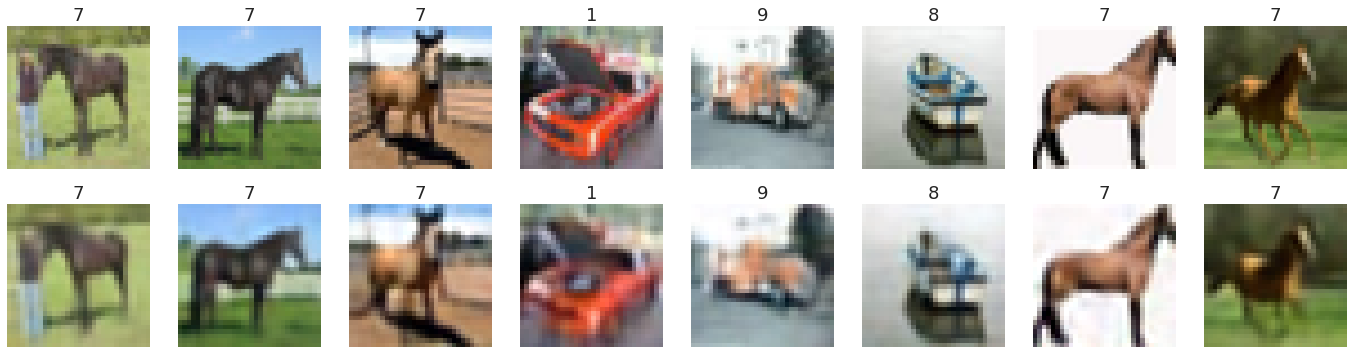

In [33]:
# on test set

def plot_predictions(model, batch_x, n=3, labx=None):
    predictions = model.predict(batch_x)
    plt.figure(figsize=(n*3, 6))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(np.clip(batch_x[i], 0, 1))
        if labx is not None:
            plt.title(label=int(labx[i].squeeze(-1)))
        plt.axis("off")
        plt.subplot(2, n, n+i+1)
        plt.imshow(np.clip(predictions[i], 0, 1))
        if labx is not None:
            plt.title(label=int(labx[i].squeeze(-1)))
        plt.axis("off")

bx, by = x_test[1]
imx = bx
imy, laby = by

plot_predictions(vae, imy, labx=laby,n=8)

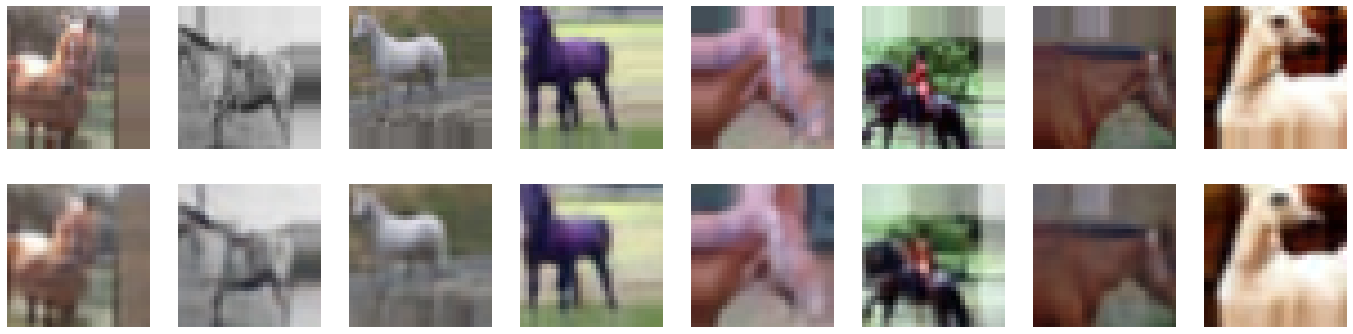

In [34]:
# on train set (to notice overfitting)

bx, by = x_train[0]

plot_predictions(vae, bx, labx=None,n=8)

## AUC score

In [35]:
from uad.diagnostic.metrics import compute_ROC, plot_ROC, binarize_set, is_binary
from sklearn.metrics import roc_curve

def score_samples_iterator(model, dataset_iterator):
    """
    Compute scores (mse) between images and predictions. 
    :param model: generic model, has to implement a predict() method
    :param dataset_iterator: iterator of MultiChannelIterator type
    Return: scores in the batch format
    """
    scores = []
    for i in range(len(dataset_iterator)):  # itere a l'infini???
        _, (ims, labs) = dataset_iterator[i]
        if (i + 1) % 50 == 0:
            print(f"making predictions on batch {i + 1}...")
        predictions = model.predict(ims)
        y_scores = np.sum((predictions - ims) ** 2, axis=(1, 2, 3))
        scores.append(y_scores)

    return np.array(scores)


def compute_ROC_iterator(model, dataset_iterator, interest_digit=7):
    """
    :param dataset_iterator: expected to be in the format given by
    MultiChannelIterator with (bx, by) == dataset_iterator[0] and then
    (images_x, labels_x) == bx
    """
    labels = []
    for i in range(len(dataset_iterator)):
        _, (ims, y_true) = dataset_iterator[i]
        labels.append(y_true.squeeze(-1))
    y_trues = np.array(labels).flatten()

    y_scores = score_samples_iterator(model, dataset_iterator).flatten()
    
    if not is_binary(y_trues):
        y_true_bin = binarize_set(y_trues, interest=interest_digit)
    else:
        y_true_bin = y_trues

    fpr, tpr, thresholds = roc_curve(y_true_bin, y_scores)

    return fpr, tpr, thresholds

fpr, tpr, _ = compute_ROC_iterator(vae, x_test)

making predictions on batch 50...
making predictions on batch 100...


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd94a2cf630>)

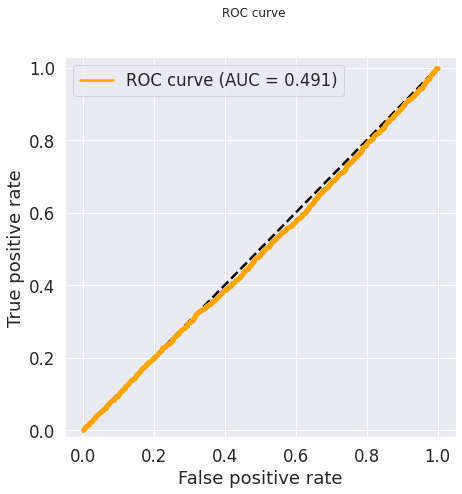

In [36]:
def plot_ROC(fpr, tpr, labels=["ROC curve"]):
    """
    Plot the ROC curves from false positives rate and true positives rate
    :param fpr: array: false positive rate
    :param tpr: array: true positive rate
    :param labels: str or list: labels to give to each curve
    :return:
    """
    if type(fpr) == list:
        fpr = np.array(fpr)
    if type(tpr) == list:
        tpr = np.array(tpr)
    if type(labels) == list:
        labels = np.array(labels)

    colours = ['r', 'g', 'b', 'm', 'y', 'k']
    symbols = ['*', '.', '-', '--', '^', 'v']
    fig, ax = plt.subplots(1, 1, figsize=(7, 7), sharex="all", sharey="all")
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    fig.suptitle("ROC curve")
    if len(fpr.shape) == 1: # single curve
        ax.plot(fpr, tpr, '.', c="orange")
        ax.plot(fpr, tpr, c="orange", label=f"{labels[0]} (AUC = {round(compute_AUC(fpr, tpr), 3)})")
    else:  # several curves to plot
        for i, (f, t, lab) in enumerate(zip(fpr, tpr, labels)):
            print(f.shape, t.shape)
            ax.plot(f, t, ".", f"{colours[i % len(colours)]}.")
            ax.plot(f, t, f"{colours[i % len(colours)]}.", label=f"{lab} (AUC = {round(compute_AUC(f, t), 3)})")
    ax.legend()
    ax.set_yscale("linear")
    ax.set_ylim(bottom=-0.02, top=1.03)
    return fig, ax

plot_ROC(fpr, tpr)

## Plot anomaly scores distribution

In [37]:
labs = []
for i in range(len(x_test)):
    _, (ims, lab) = x_test[i]
    labs.append(lab)
labs = np.array(labs).squeeze(-1).flatten()

sc = score_samples_iterator(vae, x_test).flatten()

scores_nominal = sc[labs == interest_digit]
scores_anormal = sc[labs != interest_digit]

print(scores_nominal.shape, scores_anormal.shape)

making predictions on batch 50...
making predictions on batch 100...
(2750,) (2250,)


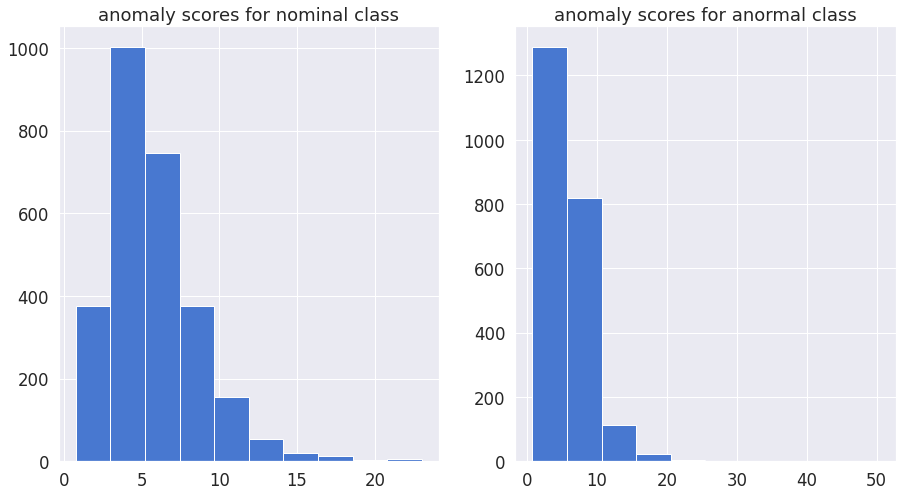

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].hist(scores_nominal)
axes[0].set_title("anomaly scores for nominal class")
axes[1].hist(scores_anormal)
axes[1].set_title("anomaly scores for anormal class")

plt.show()

We observe exactly the same distribution between normal and anormal class: that confirms the AUC score, the model is totally uninformative.